In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [160]:
# constants
end_time = 7.5  # in ms
g = 9.81  # gravity
h_com = 0.8  # height of CoM
R = 1
Q = 1e6
T = 0.009  # in s
T_max = 9 # in s
N = 300  # lookahead
t = np.linspace(0, T_max, int(T_max/T))

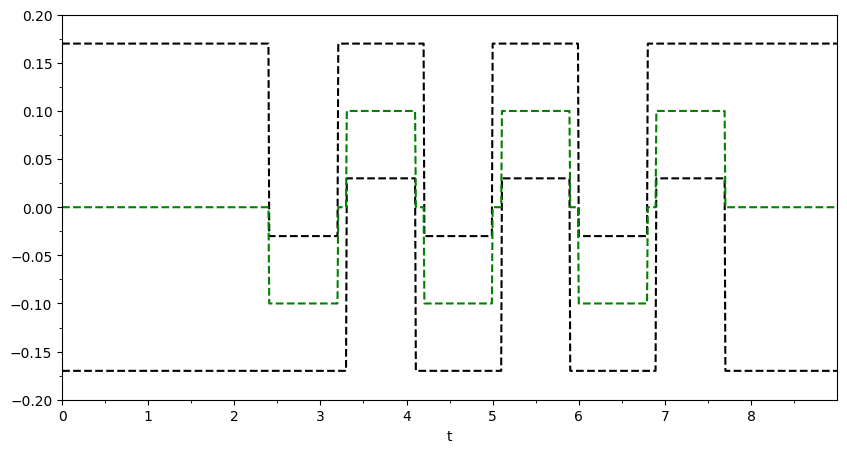

In [161]:
# Constraints
start_period_time = 2.4 # in s
max_constraint = 0.17
min_constraint = -max_constraint
max_min_constraint = -0.03
min_max_constraint = -max_min_constraint
long_period = 1 # in s
short_period = 0.8 # in s
num_periods = 3
full_period = short_period + long_period
diff_period = (long_period - short_period) / 2

z_max = np.ones(len(t)) * max_constraint
z_min = np.ones(len(t)) * min_constraint

# Apply the alternating pattern
for period_i in range(num_periods):
    # For z_max
    down_start = start_period_time + period_i * full_period
    down_end = down_start + short_period
    # For z_min
    up_start = start_period_time + period_i * full_period + (short_period + diff_period)
    up_end = up_start + short_period

    # Set the down period
    z_max[(t >= down_start) & (t < down_end)] = max_min_constraint
    # Set up period
    z_min[(t >= up_start) & (t < up_end)] = min_max_constraint

z_ref = (z_max+z_min)/2

# Plot the asymmetric square wave.
plt.figure(figsize=(10, 5))
plt.plot(t, z_max, 'k--')
plt.plot(t, z_min, 'k--')
plt.plot(t, z_ref, 'g--')
plt.xlabel('t')
plt.xlim(0, 9)
plt.xticks(np.arange(0, 9, 1))
plt.xticks(np.arange(0, 9, 0.50), minor=True)
plt.ylim(-0.2, 0.2)
plt.yticks(np.arange(-0.2, 0.21, 0.025), minor=True)
plt.show()

In [162]:
# Matrices of the analytical solution
Px = np.zeros((N,3))
for N_i in range(N):
    Px[N_i] = [1, N_i*T, N_i**2 * T**2/2 - h_com/g]
# print("Px : ", Px)

Pu = np.zeros((N,N))
# First column vector
for N_i in range(N):
    Pu[N_i, 0] = ((1+3*N_i+3*N_i**2)*T**3/6 - T * h_com/g)

for i in range(1,N):
    for j in range(1,N):
        Pu[i,j] = Pu[i-1,j-1]
# print("Pu :" , Pu)



(1300,)


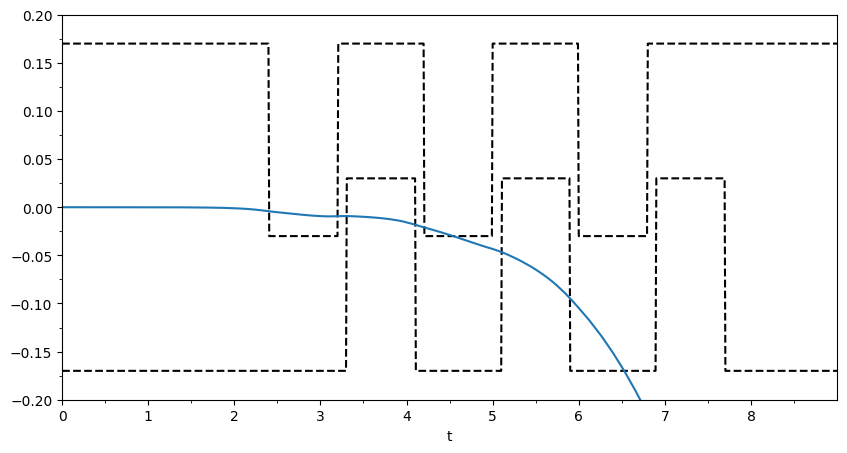

In [163]:
def compute_z(x):
    return x[0] - h_com * x[2] /g

# Iteration
z_ref = np.concatenate((z_ref, np.array([(max_constraint + min_constraint) / 2]*N)))
print(z_ref.shape)
x_values = []
z_values = []
x = np.array([
    [0],
    [0],
    [0]
])
xknext_pos_mat = np.array([
    [1, T, T**2/2],
    [0, 1, T],
    [0, 0, 1]
])
xknext_jerk_mat = np.array([
    [T**3/6],
    [T**2/2],
    [T]
])
zk_mat = np.array([1, 0, h_com/g])

# Loop
for k in range(0, int(T_max/T)):
    Zk_ref = z_ref[k:k+N]
    X_jerk = -np.linalg.inv(Pu.T @ Pu + R / Q) @ Pu.T @ (Px @ x - Zk_ref)
    x_jerk = X_jerk[0]
    xnext = xknext_pos_mat @ x + xknext_jerk_mat * x_jerk
    x = xnext[:,0]
    x_values.append(x[0])
    z_values.append(compute_z(x))

plt.figure(figsize=(10, 5))
plt.plot(t, z_max, 'k--')
plt.plot(t, z_min, 'k--')
# plt.plot(t, z_ref, 'g--')
plt.plot(t, x_values)
plt.xlabel('t')
plt.xlim(0, 9)
plt.xticks(np.arange(0, 9, 1))
plt.xticks(np.arange(0, 9, 0.50), minor=True)
plt.ylim(-0.2, 0.2)
plt.yticks(np.arange(-0.2, 0.21, 0.025), minor=True)
plt.show()